# Ejemplo Detección Data Drift

**Laboratorio de Programación Científica para la Ciencia de Datos (MDS7202)**

El objetivo de esta notebook entender como implementar algunos métodos de detección de *drifts* usando python.

Primero instalamos las librerias necesarias:

In [1]:
# primero instalamos alibi_detect
!pip -qq install alibi_detect

Para ilustrar de mejor manera los conceptos, se generarán artificialmente los conjuntos X e y

Accuracy: 0.91


<Axes: >

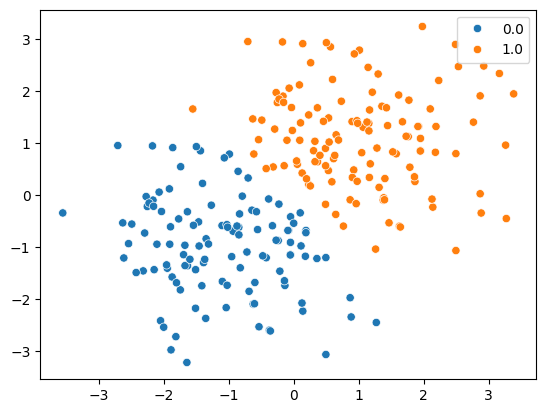

In [2]:
from scipy.stats import multivariate_normal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def true_model(X, slope = -1):

  '''
  Modelo "verdadero", mapea X -> y
  '''

  z = X[:, 0] * slope
  y = np.where(X[:, 1] > z, 1, 0)
  y = np.expand_dims(y.astype(float), axis = 1)

  return y

def get_X(mu = 1,
          sigma = 1,
          phi_1 = 0.5,
          phi_2 = 0.5,
          random_state = 0,
          N = 240,
          ):

  '''
  Genera datos de X usando 2 gaussianas multivariadas
  '''

  ref_norm_0 = multivariate_normal([-mu,-mu], np.eye(2) * sigma ** 2)
  ref_norm_1 = multivariate_normal([mu, mu], np.eye(2) * sigma ** 2)

  X_0 = ref_norm_0.rvs(size = int(N * phi_1),random_state = random_state)
  X_1 = ref_norm_1.rvs(size = int(N * phi_2),random_state = random_state)

  return np.vstack([X_0, X_1]) # X = phi_1 * N_1 + phi_2 * N_2

# get data
X = get_X()
y = true_model(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 0)

# train clf
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# measure performance
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# plot data
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y[:, 0])

## Detectando Drifts

En esta sección intentaremos detectar los 3 tipos de drifts: **Data Drift**, **Target Drift** y **Concept Drift**. Para esto, ocuparemos el método `MMDDrift` de la librería `alibi_detect`. Pueden encontrar diferentes métodos para detectar drifts en este [enlace](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods.html).

<div style="text-align: center;">
    <img src="https://docs.seldon.io/projects/alibi-detect/en/latest/_images/drift_pipeline.png" style="width: 50%;">
</div>


[Maximum Mean Discrepancy](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/mmddrift.html) es un método basado en [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953), el cual usa la distancia MMD para computar la distancia entre ambas distribuciones. La distancia MMD se define como:

\begin{equation}
MMD(F, p, q) = ||\mu_p - \mu_q||^2_F
\end{equation}

donde $\mu_p$ y $\mu_q$ representa la media de las distribuciones $p$ y $q$, respectivamente. De esta manera, la distancia MMD puede ser interpretada como la resta entre las medias de ambas distribuciones en el kernel de Hilbert $F$, la cual puede ser computada usando el famoso *kernel trick*.

Veamos como implementar este modelo:

In [3]:
# train drift detector
from alibi_detect.cd import MMDDrift

# noten como se genera un detector para X e y por separado
data_detector = MMDDrift(X, backend='pytorch', p_val=.05)
target_detector = MMDDrift(y, backend='pytorch', p_val=.05)

# función utilitaria para detectar drift
def drift_detection(detector, new_data):

  '''
  Función que recibe un detector de alibi y nueva data.
  Devuelve un bool y p-value de test respecto a la presencia de drift
  '''

  output = detector.predict(new_data)['data']
  is_drift = bool(output['is_drift'])
  p_value = output['p_val']

  return is_drift, p_value

Con el chunk anterior, estamos tomando como referencia los datos de entrenamiento ($X$, $y$) para después evaluar si existe algun cambio significativo con respecto a la distribución de estos datos. Noten que para este caso particular NO usaremos una etapa de reducción de dimensionalidad dada la baja dimensionalidad de $X$

### Data Drift

El primer caso que estudiaremos es el **Data Drift**, es decir, cuando existe un cambio en la distribución de los datos $P(X)$. Podemos definir formalmente este problema como:

\begin{equation}
P(X) \neq P_{ref}(X)
\end{equation}

Para esto, forzaremos un cambio en los parámetros $\mu, \sigma$ en $X$:

New Accuracy: 0.98
Data drift? True
Target drift? False


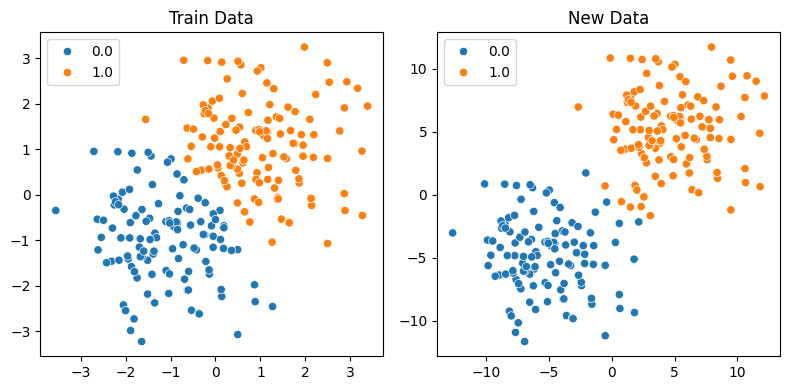

In [4]:
# get new data
new_X = get_X(mu = 5, sigma = 3) # se cambian algunos parametros de X
new_y = true_model(new_X)

# measure performance on new data
y_pred = clf.predict(new_X)
accuracy = accuracy_score(new_y, y_pred)
print(f'New Accuracy: {accuracy:.2f}')

# drift detection
data_drift, p_value = drift_detection(data_detector, new_X)
target_drift, p_value = drift_detection(target_detector, new_y)

print('Data drift?', data_drift)
print('Target drift?', target_drift)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y[:, 0], ax = ax[0])
ax[0].set_title('Train Data')
sns.scatterplot(x=new_X[:, 0], y=new_X[:, 1], hue=new_y[:, 0], ax = ax[1])
ax[1].set_title('New Data')
plt.tight_layout()
plt.show()

A partir del ejercicio anterior, concluimos:
- El modelo logra detectar el cambio en la distribución de los datos $X$
- A pesar del Data Drift, nuestro modelo no presenta pérdidas en su performance (*Accuracy* se mantiene igual). OJO que esto es un caso puntual y no siempre pasa, esto puede cambiar para otros datos.
- Esto es interesante pues nos revela que no todos los drift son perjudiciales para nuestro modelo

### Target Drift

El segundo caso que estudiaremos es el **Target Drift**, es decir, cuando existe un cambio en la distribución de los datos $P(y)$. Podemos definir formalmente este problema como:

\begin{equation}
P(y) \neq P_{ref}(y)
\end{equation}

Para esto, forzaremos que la distribución de los datos $y$ cambien de manera exógena:

New Accuracy: 0.55
Data drift? False
Target drift? True


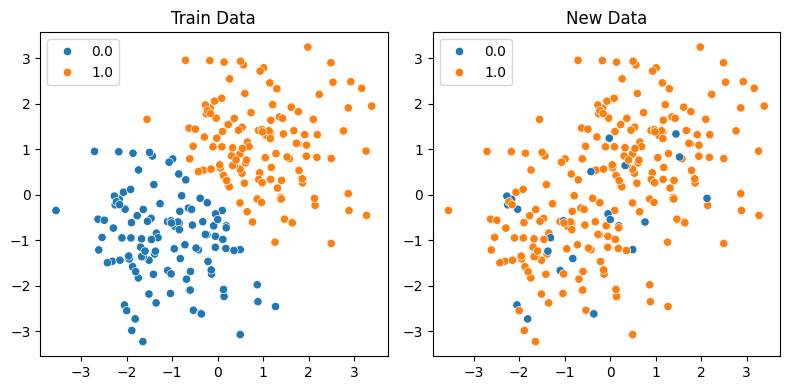

In [5]:
# get new data
new_X = get_X()
new_y = np.random.choice([0.0, 1.0], size=[240, 1], p=[0.1, 0.9]) # se cambia distribución de y

# measure performance
y_pred = clf.predict(new_X)
accuracy = accuracy_score(new_y, y_pred)
print(f'New Accuracy: {accuracy:.2f}')

# drift detection
data_drift, p_value = drift_detection(data_detector, new_X)
target_drift, p_value = drift_detection(target_detector, new_y)

print('Data drift?', data_drift)
print('Target drift?', target_drift)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y[:, 0], ax = ax[0])
ax[0].set_title('Train Data')
sns.scatterplot(x=new_X[:, 0], y=new_X[:, 1], hue=new_y[:, 0], ax = ax[1])
ax[1].set_title('New Data')
plt.tight_layout()
plt.show()

A partir del resultado anterior, se obtienen las siguientes conclusiones:

- Nuestro modelo logra detectar de forma efectiva el cambio en la distribución de $y$
- A diferencia del caso anterior, se obtiene una pérdida significativa en la performance del modelo (0.99 vs 0.52 *Accuracy*)

### Concept Drift

Finalmente, el tercer caso que estudiaremos es el **Concept Drift**, es decir, cuando existe un cambio en el modelo o en la distribución de los datos $P(y|X)$. Podemos definir formalmente este problema como:

\begin{equation}
P(y|X) \neq P_{ref}(y|X)
\end{equation}

Para esto, forzaremos un cambio en los parámetros del modelo $f$:

New Accuracy: 0.22
Data drift? False
Target drift? False


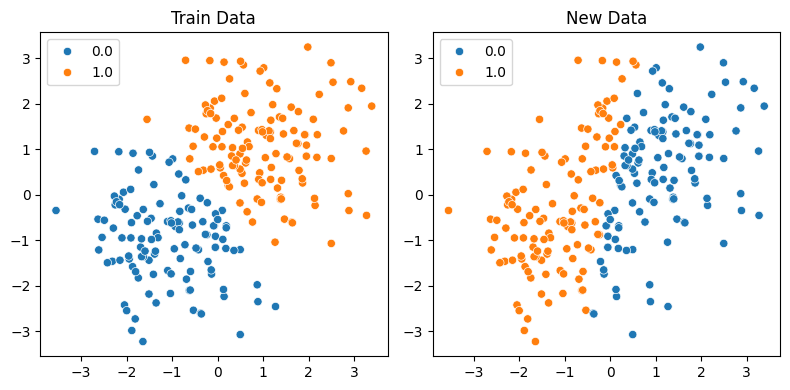

In [6]:
# get new data
new_X = get_X()
new_y = true_model(new_X, slope = 5) # se cambia modelo f

# measure performance
y_pred = clf.predict(new_X)
accuracy = accuracy_score(new_y, y_pred)
print(f'New Accuracy: {accuracy:.2f}')

# drift detection
data_drift, p_value = drift_detection(data_detector, new_X)
target_drift, p_value = drift_detection(target_detector, new_y)

print('Data drift?', data_drift)
print('Target drift?', target_drift)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y[:, 0], ax = ax[0])
ax[0].set_title('Train Data')
sns.scatterplot(x=new_X[:, 0], y=new_X[:, 1], hue=new_y[:, 0], ax = ax[1])
ax[1].set_title('New Data')
plt.tight_layout()
plt.show()

A partir del ejercicio anterior, se obtienen las siguientes conclusiones:
- Nuestro modelo NO logra detectar el cambio en la distribución $P(y|X)$
- Pese a lo anterior, se observa una pérdida significativa en el performance del modelo (0.99 vs 0.23 *Accuracy*)